In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

In [3]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = #please enter your resource id here ,
    location = "eastus"
)

In [4]:
print([backend.name() for backend in provider.backends()])

['ionq.qpu', 'ionq.simulator']


In [5]:
# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(3, 3)
circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0, 1, 2])

# Print out the circuit
circuit.draw()

┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2

In [6]:
simulator_backend = provider.get_backend("ionq.simulator")

In [7]:
job = simulator_backend.run(circuit, shots=100)
job_id = job.id()
print("Job id", job_id)

Job id 32bd14ee-8120-11ec-8f94-367dda17a95d


In [8]:
job_monitor(job)

Job Status: job has successfully run


In [9]:
result = job.result()

In [10]:
print(result)

Result(backend_name='ionq.simulator', backend_version='1', qobj_id='Qiskit Sample - 3-qubit GHZ circuit', job_id='32bd14ee-8120-11ec-8f94-367dda17a95d', success=True, results=[ExperimentResult(shots=100, success=True, meas_level=2, data=ExperimentResultData(counts=defaultdict(<class 'int'>, {'000': 50, '111': 50}), probabilities=defaultdict(<class 'int'>, {'000': 0.5, '111': 0.5})), header=QobjExperimentHeader(meas_map='[0, 1, 2]', name='Qiskit Sample - 3-qubit GHZ circuit', num_qubits='3', qiskit='True'))])


{'000': 50, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 50}


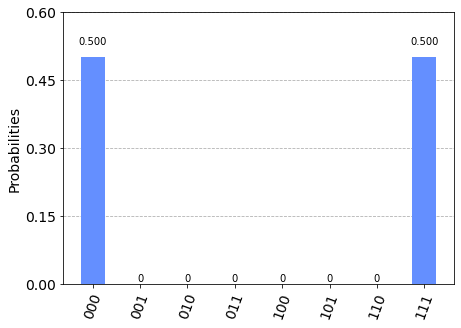

In [11]:
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)